# Imports

In [47]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pandas as pd
from datetime import datetime 
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import pickle
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from arch import arch_model

In [2]:
warnings.filterwarnings('ignore')

# Getting Data

In [3]:
ticker = yf.Ticker('msft')
df = ticker.history(interval='1d', start='2010-01-01', end='2023-01-01')

# Creating dummy date index to prevent frequency warnings/errors (missing value imputation not necessary because there should
# be no data on days the market is not open)
dummy_dates = pd.date_range(end=datetime.today(), periods=len(df))
df['Dummy Date'] = dummy_dates.date
df.index = df.index.tz_convert(None)
df = df.reset_index()
df = df.set_index('Dummy Date')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dummy Date,,,,,,,,
2014-05-06,2010-01-04 05:00:00,23.372009,23.738389,23.349110,23.623896,38409100,0.0,0.0
2014-05-07,2010-01-05 05:00:00,23.547568,23.738391,23.387276,23.631529,49749600,0.0,0.0
2014-05-08,2010-01-06 05:00:00,23.570467,23.723126,23.295682,23.486506,58182400,0.0,0.0
2014-05-09,2010-01-07 05:00:00,23.379642,23.433074,23.043794,23.242250,50559700,0.0,0.0
2014-05-10,2010-01-08 05:00:00,23.112492,23.570466,23.081959,23.402542,51197400,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3272 entries, 2014-05-05 to 2023-04-19
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3272 non-null   datetime64[ns]
 1   Open          3272 non-null   float64       
 2   High          3272 non-null   float64       
 3   Low           3272 non-null   float64       
 4   Close         3272 non-null   float64       
 5   Volume        3272 non-null   int64         
 6   Dividends     3272 non-null   float64       
 7   Stock Splits  3272 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 230.1+ KB


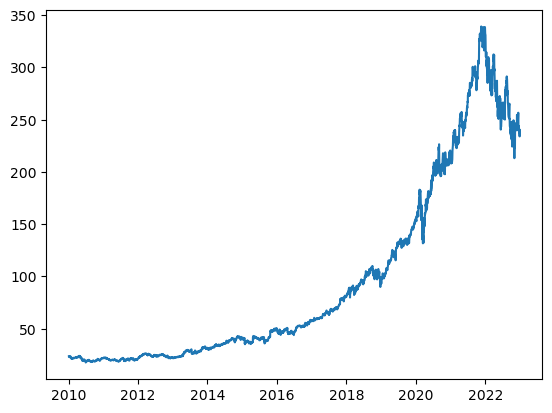

In [4]:
plt.plot(df['Date'], df['Close'])
plt.show()

# Stationarity

In [5]:
result = adfuller(df['Close'])
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: 0.25634361140319845
ADF P-value: 0.9752504737420765


Based on the p-value of the ADF test, we fail to reject the null hypothesis and therefore, the data is not stationary.

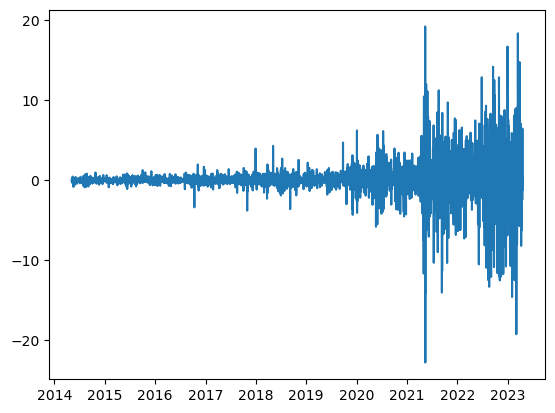

In [6]:
returns = df['Close'].diff().dropna()
plt.plot(returns)
plt.show()

In [7]:
result = adfuller(returns)
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -16.034379050518524
ADF P-value: 6.008577504057525e-29


By taking the first difference of the closing price, we see that the resulting p-value of the ADF test is now less than 0.05, so we can reject the null hypothesis and conclude that the returns are stationary. We also can conlude that the parameter, d, corresponding to the integrated component of our SARIMA model should be set to 1.

# Splitting Train/Test Data

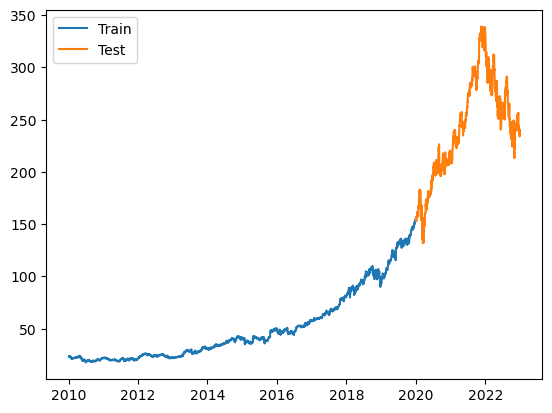

In [4]:
max_date = df.loc[df['Date'] < datetime(2020, 1, 1)].index.max()
max_train_idx = df.index.get_loc(max_date)
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='Train')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='Test')
plt.legend()
plt.show()

# PACF and ACF Plots

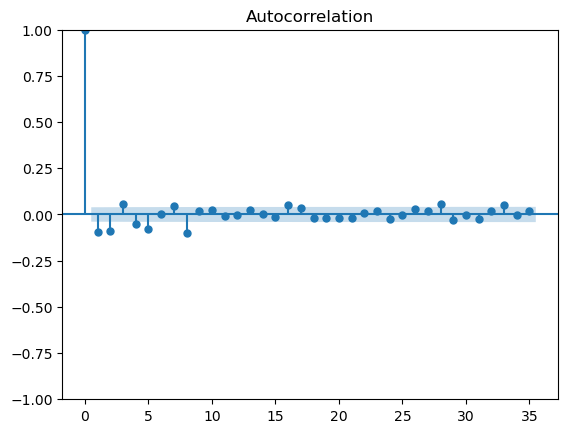

In [18]:
plot_acf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna())
plt.show()

Based on the ACF plot, possible values of the moving average (MA) component of the model could be {1, 2, 3, 4, 5, 8}

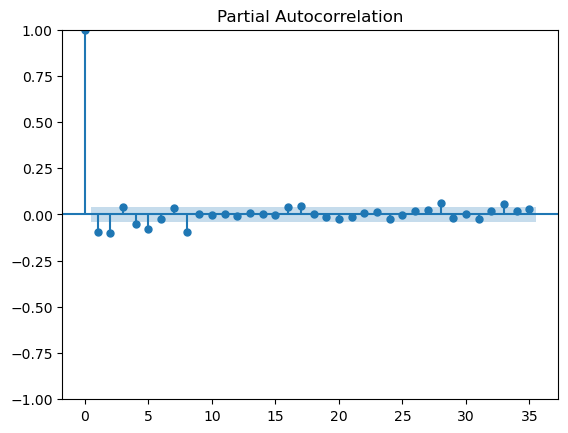

In [19]:
plot_pacf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna(), method='ywm')
plt.show()

Based on the PACF plot, possible values of the autoregressive (AR) component of the model could be {1, 2, 4, 5, 8}

# ARIMA Parameter Tuning

In [30]:
model = auto_arima(df.iloc[:max_train_idx + 1]['Close'], start_p=1, max_p=8, d=1, start_q=1, max_q=8, 
                   seasonal=False, information_criterion='aic')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -3111.449
Date:                Wed, 19 Apr 2023   AIC                           6242.899
Time:                        23:55:48   BIC                           6301.199
Sample:                             0   HQIC                          6264.058
                               - 2516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0592      0.019      3.183      0.001       0.023       0.096
ar.L1         -0.6735      0.092     -7.288      0.000      -0.855      -0.492
ar.L2         -0.2560      0.105     -2.434      0.015      -0.462      -0.050
ar.L3          0.2353      0.084      2.801      0.005       0.071       0.400
ar.L4          0.5391      0.057      9.527      0.000       0.428       0.650
ma.L1          0.5692      0.090      6.356      0.000       0.394       0.745
ma.L2          0.0891      0.097      0.920      0.358      -0.101       0.279
ma.L3         -0.2754      0.068     -4.032      0.000      -0.409      -0.142
ma.L4         -0.5690      0.049    -11.701      0.000      -0.664      -0.474
sigma2         0.6953      0.008     83.547      0.000       0.679       0.712
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9566.40
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              16.48   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA (4, 1, 4) Model

In [5]:
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(4, 1, 4), missing='raise', freq='D')
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7001      0.106     -6.606      0.000      -0.908      -0.492
ar.L2         -0.2961      0.135     -2.195      0.028      -0.560      -0.032
ar.L3          0.1995      0.109      1.826      0.068      -0.015       0.414
ar.L4          0.5158      0.068      7.618      0.000       0.383       0.648
ma.L1          0.6037      0.103      5.846      0.000       0.401       0.806
ma.L2          0.1391      0.125      1.111      0.266      -0.106       0.384
ma.L3         -0.2321      0.090     -2.590      0.010      -0.408      -0.056
ma.L4         -0.5402      0.057     -9.559      0.000      -0.651      -0.429
sigma2         0.7001      0.008     82.973      0.000       0.684       0.717


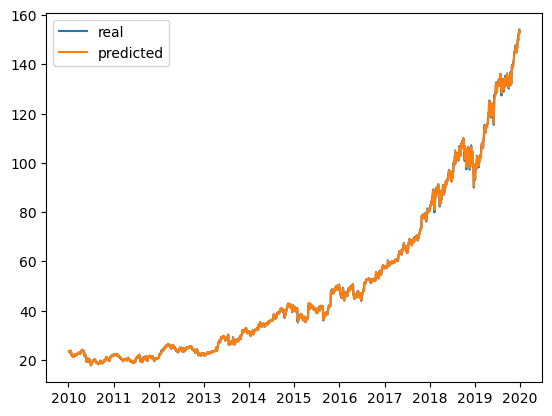

In [6]:
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='real')
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], results.fittedvalues[1:], label='predicted')
plt.legend()
plt.show()

In [7]:
# Train Results
mse = mean_squared_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mae = mean_absolute_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mape = mean_absolute_percentage_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 0.7001027739484755
RMSE: 0.8367214434616072
MAE: 0.5064793541665424
MAPE: 0.010162898008033753


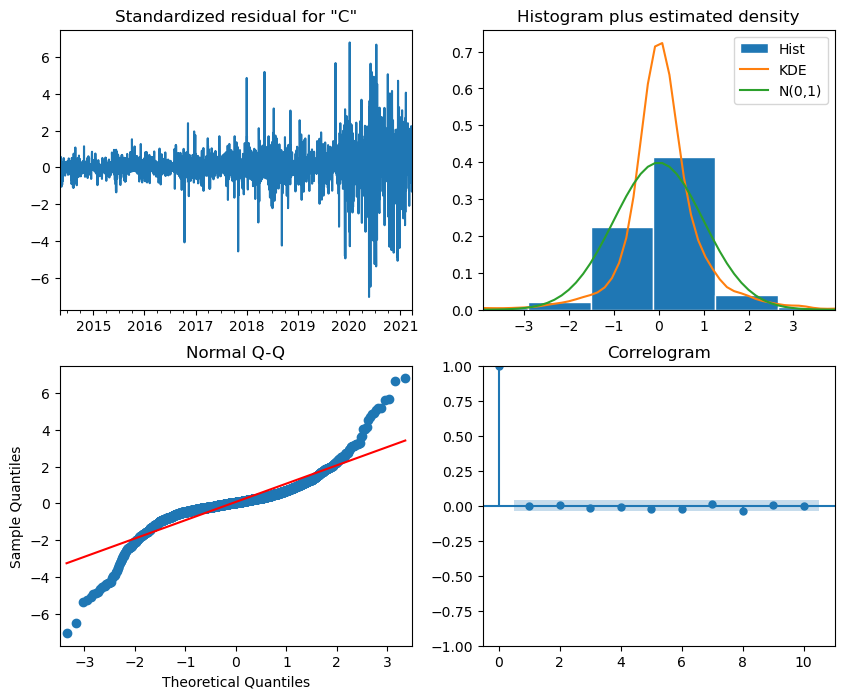

In [12]:
fig = plt.figure(figsize=(10, 8))
results.plot_diagnostics(fig=fig)
plt.show()

Based on the diagnostic plots, the residuals do appear to be normally distributed with mean 0 and do not appear to be correlated. However, it is clear that there is a change in volatility over time -> heteroskedasticity. To confirm these conclusions, we run an Ljung-Box test to check for autocorrelation and a Breusch Pagan test to check for heteroskedasticity. 

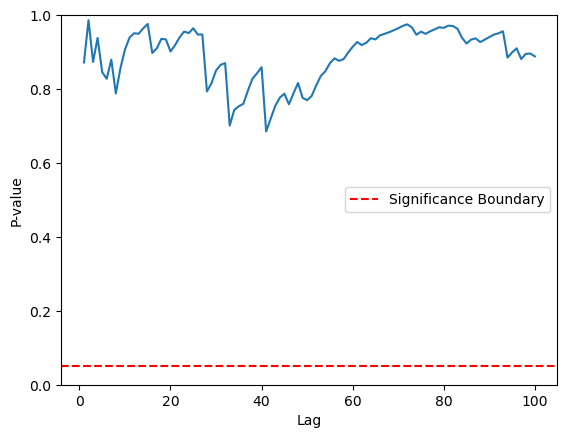

In [33]:
# Use Ljung-Box to statistically test for autocorrelation of residuals in the first 100 lags
resid_test = acorr_ljungbox(results.resid, lags=100, return_df=True)
plt.plot(resid_test['lb_pvalue'])
plt.axhline(0.05, linestyle='--', color='red', label='Significance Boundary')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('P-value')
plt.xlabel('Lag')
plt.show()

The null hypothesis of the Ljung-Box test is that the residuals are independently distributed. Based on the figure above, we fail to reject the null hypothesis for the first 100 lags and conclude that the residuals are independently distributed (i.e. they do not exhibit serial correlation).

In [29]:
# Breusch-Pagan test for heteroskedasticity
n = len(df.iloc[1:max_train_idx + 1]) 
exog = np.zeros((n, 2))
exog[:, 0], exog[:, 1] = df.iloc[1:max_train_idx + 1]['Date'], df.iloc[1:max_train_idx + 1]['Close']

bp_test = het_breuschpagan(results.resid[1:], exog)
print('BP Test Statistic: {}'.format(bp_test[0]))
print('BP P-value: {}'.format(bp_test[1]))

BP Test Statistic: 28.26470550092716
BP P-value: 1.0580773289035797e-07


Based on the results of the Breusch Pagan test, we reject the null hypothesis that the residuals are homoskedastic and conclude that there is a change in variance/volatility over time. To model this volatility we will use a GARCH model.

# Rolling Forecast Origin

In [ ]:
predictions = results.fittedvalues.to_list()

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    model = SARIMAX(df.iloc[i:max_train_idx + 1 + i]['Close'], order=(4, 1, 4), initialization='approximate_diffuse').fit(
                                                    maxiter=200)
    
    # Forecast
    forecast = model.forecast()[0]
    predictions.append(forecast)

df['Close Predictions'] = predictions

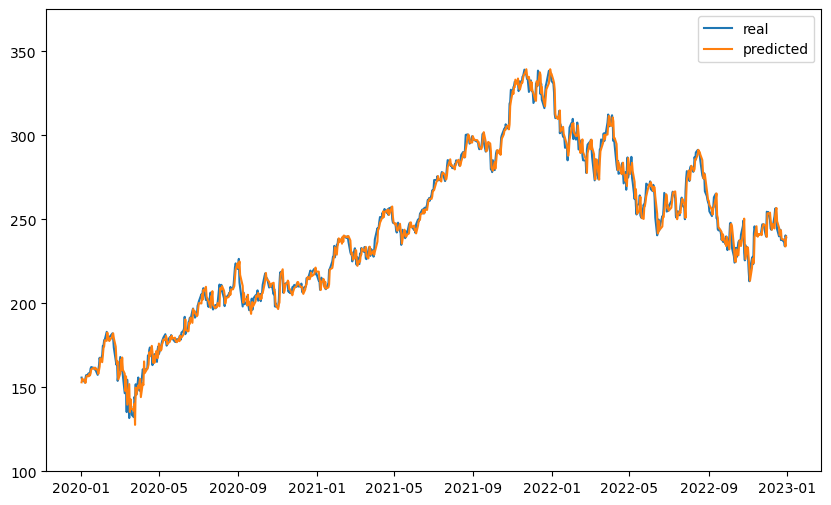

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='real')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close Predictions'], label='predicted')
plt.ylim([100, 375])
plt.legend()
plt.show()

In [45]:
# Test Results
mse = mean_squared_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mae = mean_absolute_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mape = mean_absolute_percentage_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 23.488655479367647
RMSE: 4.8465096182064515
MAE: 3.662506012040692
MAPE: 0.015825895439207174


# Modeling Volatility

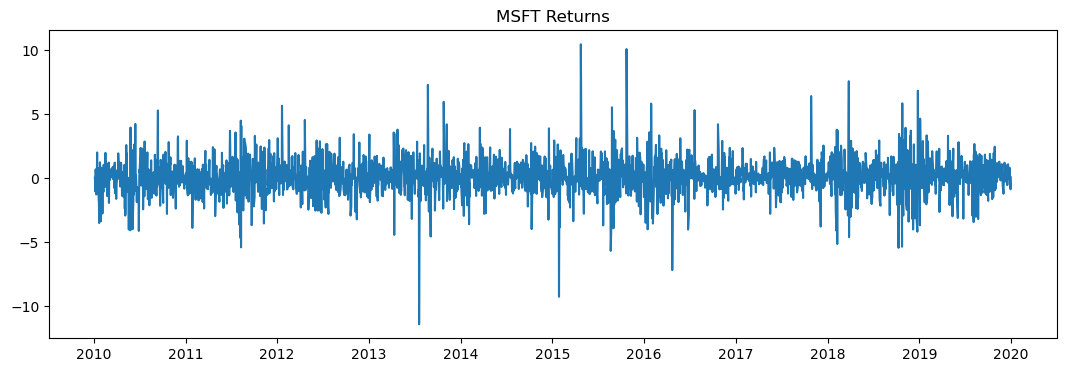

In [56]:
returns = 100 * df.iloc[:max_train_idx + 1]['Close'].pct_change().dropna()

plt.figure(figsize=(13, 4))
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], returns)
plt.title('MSFT Returns')
plt.show()

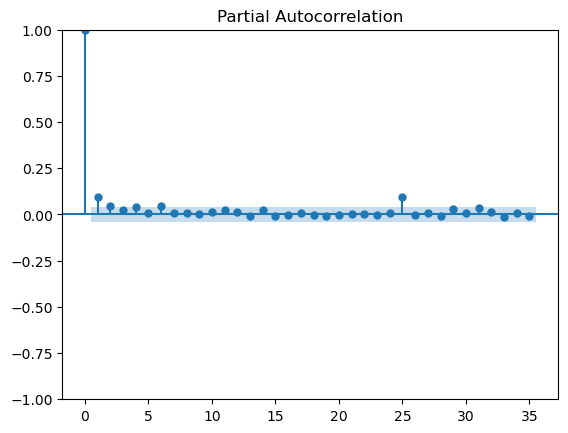

In [54]:
# PACF to determine order of AR component
plot_pacf(returns ** 2)
plt.show()

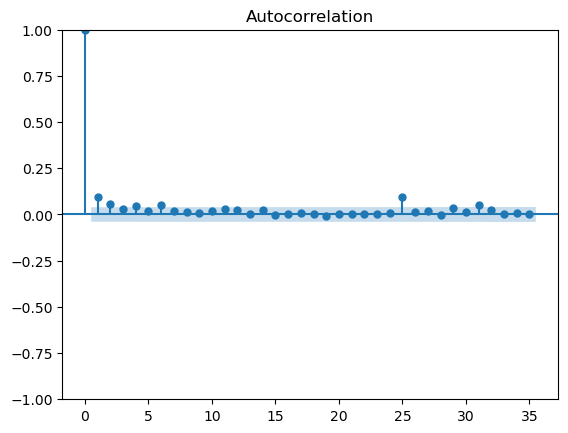

In [55]:
# ACF to determine order of MA component
plot_acf(returns ** 2)
plt.show()

Based on the acf/pacf plots, possible orders of the MA component include {1, 2} and possible orders of the AR component include {1}.

In [71]:
# GARCH(1, 2)
model_fit = arch_model(returns, p=1, q=2, vol='Garch').fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 14861.892567752107
Iteration:      2,   Func. Count:     17,   Neg. LLF: 73183360778.41333
Iteration:      3,   Func. Count:     26,   Neg. LLF: 4983.578056499343
Iteration:      4,   Func. Count:     34,   Neg. LLF: 4468.102986982105
Iteration:      5,   Func. Count:     41,   Neg. LLF: 4409.84180532495
Iteration:      6,   Func. Count:     48,   Neg. LLF: 4396.502226100782
Iteration:      7,   Func. Count:     55,   Neg. LLF: 4391.2073995340015
Iteration:      8,   Func. Count:     61,   Neg. LLF: 4391.325987771596
Iteration:      9,   Func. Count:     68,   Neg. LLF: 4391.024140653344
Iteration:     10,   Func. Count:     75,   Neg. LLF: 4390.901499457797
Iteration:     11,   Func. Count:     81,   Neg. LLF: 4390.901326964392
Iteration:     12,   Func. Count:     87,   Neg. LLF: 4390.901297997705
Iteration:     13,   Func. Count:     93,   Neg. LLF: 4390.901289210319
Iteration:     14,   Func. Count:     98,   Neg. LLF: 4390.9012

In [72]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4390.90
Distribution:                  Normal   AIC:                           8791.80
Method:            Maximum Likelihood   BIC:                           8820.95
                                        No. Observations:                 2515
Date:                Thu, Apr 20 2023   Df Residuals:                     2514
Time:                        16:37:35   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1169  2.663e-02      4.390  1.132e-05 [6.471e-02,  0.169]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3496      0.132      2.656  7.904e-03 [9.164e-02,  0.608]
alpha[1]       0.1516  4.869e-02      3.114  1.848e-03 [5.617e-02,  0.247]
beta[1]        0.6482      0.204      3.183  1.457e-03   [  0.249,  1.047]
beta[2]        0.0414      0.147      0.281      0.779   [ -0.247,  0.330]
==========================================================================

Covariance estimator: robust
"""

From the model summary, we can see that the second beta coefficient is not statistically significant, we can remove it and stick with a GARCH (1, 1) model.

In [74]:
# GARCH (1, 1)
model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12845.824589142629
Iteration:      2,   Func. Count:     15,   Neg. LLF: 37626893757.506775
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4952.356822804589
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4456.258470635162
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4393.221570853625
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4390.965102806851
Iteration:      7,   Func. Count:     48,   Neg. LLF: 4390.954825603183
Iteration:      8,   Func. Count:     53,   Neg. LLF: 4390.951748425716
Iteration:      9,   Func. Count:     58,   Neg. LLF: 4390.951726117657
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4390.951724810436
Iteration:     11,   Func. Count:     67,   Neg. LLF: 4390.951724810761
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4390.951724810436
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 

In [76]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4390.95
Distribution:                  Normal   AIC:                           8789.90
Method:            Maximum Likelihood   BIC:                           8813.22
                                        No. Observations:                 2515
Date:                Thu, Apr 20 2023   Df Residuals:                     2514
Time:                        16:39:16   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1174  2.676e-02      4.386  1.153e-05 [6.492e-02,  0.170]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3392      0.122      2.783  5.389e-03   [  0.100,  0.578]
alpha[1]       0.1473  4.487e-02      3.283  1.026e-03 [5.938e-02,  0.235]
beta[1]        0.6987  8.046e-02      8.684  3.829e-18   [  0.541,  0.856]
==========================================================================

Covariance estimator: robust
"""

Now we see that all the coeficients are statistically significant and are ready to evaluate the model on the test data using a rolling forecast origin

In [89]:
# Rolling Forecast Origin
vol_preds = [np.nan for _ in range(max_train_idx + 1)] # pad training data with nan values because we only predict on test set

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    returns = 100 * df.iloc[i:i + max_train_idx + 1]['Close'].pct_change().dropna()
    model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit(disp='off')
    
    # Forecast
    forecast = model_fit.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1][0])
    vol_preds.append(vol)

df['Volatility Predictions'] = vol_preds

100%|████████████████████████████████████████████████████████████████████████████████| 756/756 [00:17<00:00, 43.41it/s]


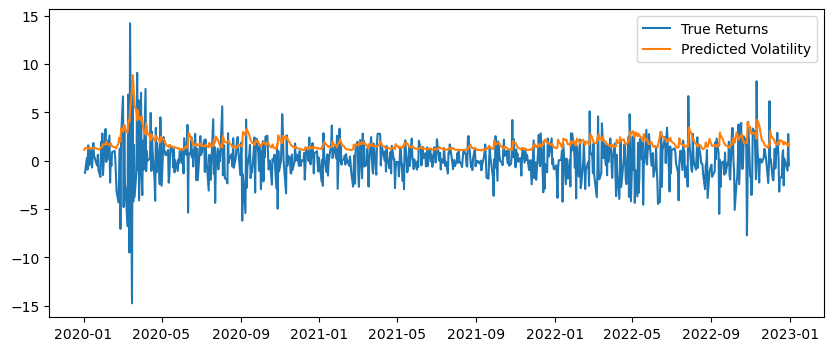

In [92]:
plt.figure(figsize=(10, 4))
true_returns = 100 * df.iloc[max_train_idx + 1:]['Close'].pct_change().dropna()
plt.plot(df.iloc[max_train_idx + 2:]['Date'], true_returns, label='True Returns')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Volatility Predictions'], 
         label='Predicted Volatility')
plt.legend()
plt.show()

We see that the model does a great job of modeling the volatility of the stock's returns.

In [98]:
# Saving Data
df = df.set_index('Date')
df['Returns'] = 100 * df['Close'].pct_change()
df['Test Marker'] = [np.nan if x != max_train_idx + 1 else 'Start of Test Data' for x in range(len(df))]
df.to_csv('Processed Microsoft Data.csv')